# Case study: IMT spurious emission and RAS (generic single-interferer worst-case)

## License

```
HOWTO: Calculate level of interference in radio-astronomical
observations produced from a single IMT device in spurious domain.
Copyright (C) 2015+  Benjamin Winkel (bwinkel@mpifr.de)

This program is free software; you can redistribute it and/or
modify it under the terms of the GNU General Public License
as published by the Free Software Foundation; either version 2
of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program; if not, write to the Free Software
Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
```

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as con
from pycraf import conversions as cnv
from pycraf import pathprof, protection, antenna

## System parameters

To protect other services, in almost all bands, IMT has to ensure that spurious emissions of each terminal (base stations and user equipment) are lower the $-$$30~\mathrm{dBm/MHz}$. Therefore, one can easily work out necessary separation distances for the single-interferer worst-case scenario (as a generic study, aka flat-Earth) for the various RA.769 thresholds, continuum, spectral-line, or VLBI. Note that the spurious limit is to be understood as EIRP.

In [3]:
# IMT transmitter; 
P_spurious = -30 * cnv.dBm_MHz

## Compatibility / Separation distances

We'll produce one plot for each threshold type, that contains curves for various frequencies and Tx heights. **No clutter correction is applied in this worst-case scenario!**

In [4]:
HEIGHTS = [40, 1.5] * u.m

In [5]:
def path_atten(freq, height, max_dist=200 * u.km, ras_height=50 * u.m):
    
    lon_t, lon_r = 0 * u.deg, 0 * u.deg
    lat_t, lat_r = 50 * u.deg, 50 * u.deg
    h_tg, h_rg = height, ras_height
    G_t, G_r = 0. * cnv.dBi, 0. * cnv.dBi

    temperature = 293.15 * u.K
    pressure = 1013. * u.hPa

    time_percent = 2 * u.percent
    DN, N0 = 38. * cnv.dimless / u.km, 324. * cnv.dimless

    hprof_step = 50 * u.m
    hprof_data = pathprof.height_path_data_generic(
        max_dist, hprof_step, lon_t, lat_t,
        )
    
    results = pathprof.atten_path_fast(
        freq, temperature, pressure,
        h_tg, h_rg, time_percent,
        hprof_data,
        )
    
    return hprof_data['distances'][5:], results['L_b'][5:]

### Continuum thresholds

In [6]:
tab = protection.ra769_limits()[5:11]

In [7]:
tab

frequency,bandwidth,T_A,T_rx,T_rms,P_rms_nu,Plim,Plim_nu,Slim,Slim_nu,Efield,Efield_norm
MHz,MHz,K,K,mK,dB(W / Hz),dB(W),dB(W / Hz),dB(W / m2),dB(W / (Hz m2)),dB(uV2 / m2),dB(uV2 / m2)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
408,4,25,60,0.962,-258.8,-202.9,-268.8,-189.2,-255.1,-43.4,-49.3
611,6,20,60,0.730,-260.0,-202.2,-270.0,-185.0,-252.8,-39.2,-47.0
1414,27,12,10,0.095,-268.8,-204.5,-278.8,-180.1,-254.4,-34.3,-48.6
1665,10,12,10,0.156,-266.7,-206.7,-276.7,-180.8,-250.8,-35.0,-45.0
2695,10,12,10,0.156,-266.7,-206.7,-276.7,-176.6,-246.6,-30.9,-40.9
4995,10,12,10,0.156,-266.7,-206.7,-276.7,-171.3,-241.3,-25.5,-35.5


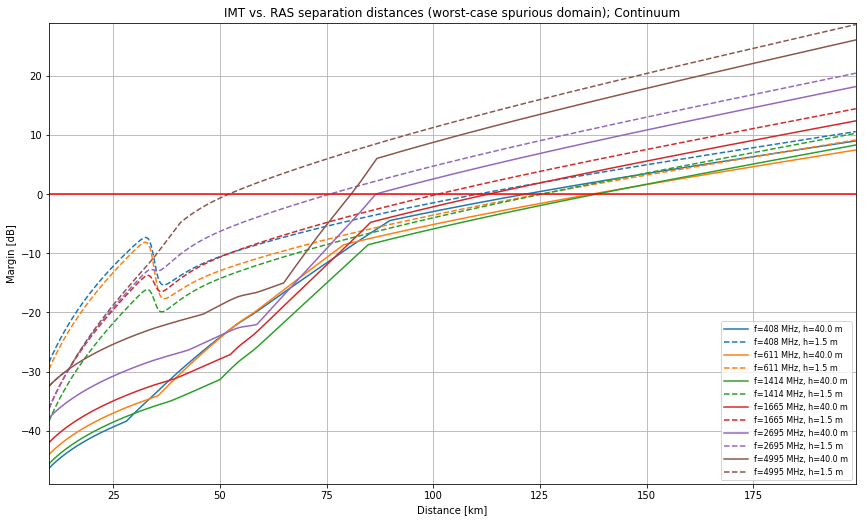

In [8]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.close()
fig = plt.figure(figsize=(14, 8))
ax = fig.add_axes((0.1, 0.1, 0.8, 0.8))
for freq, Plim_nu, color in zip(tab['frequency'], tab['Plim_nu'], colors):
    
    for height, ls in zip(HEIGHTS, ['-', '--']):

        dist, atten = path_atten(freq, height)
        
        margin = Plim_nu.to_value(cnv.dBm_MHz) - (
            P_spurious.to_value(cnv.dBm_MHz) - atten.to_value(cnv.dB)
            )
        
        ax.plot(
            dist, margin,
            ls=ls, c=color, label='f={:.0f}, h={:.1f}'.format(freq, height)
            )

ax.legend(
    *ax.get_legend_handles_labels(), 
    loc='lower right', fontsize=8, handlelength=3
    )
ax.axhline(0, c='r')
ax.set_xlim((10, 199))
ax.set_ylim((-49, 29))
ax.set_xlabel('Distance [km]')
ax.set_ylabel('Margin [dB]')
ax.grid()
ax.set_title('IMT vs. RAS separation distances (worst-case spurious domain); Continuum')
plt.show()

### Spectral line thresholds

In [9]:
tab = protection.ra769_limits(mode='spectroscopy')[[0, 1, 3, 4]]

In [10]:
tab

frequency,bandwidth,T_A,T_rx,T_rms,P_rms_nu,Plim,Plim_nu,Slim,Slim_nu,Efield,Efield_norm
MHz,kHz,K,K,mK,dB(W / Hz),dB(W),dB(W / Hz),dB(W / m2),dB(W / (Hz m2)),dB(uV2 / m2),dB(uV2 / m2)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
327,10,40,60,22.361,-245.1,-215.1,-255.1,-203.4,-243.4,-57.6,-37.6
1420,20,12,10,3.479,-253.2,-220.2,-263.2,-195.7,-238.7,-49.9,-32.9
1665,20,12,10,3.479,-253.2,-220.2,-263.2,-194.3,-237.3,-48.5,-31.5
4830,50,12,10,2.200,-255.2,-218.2,-265.2,-183.1,-230.0,-37.3,-24.3


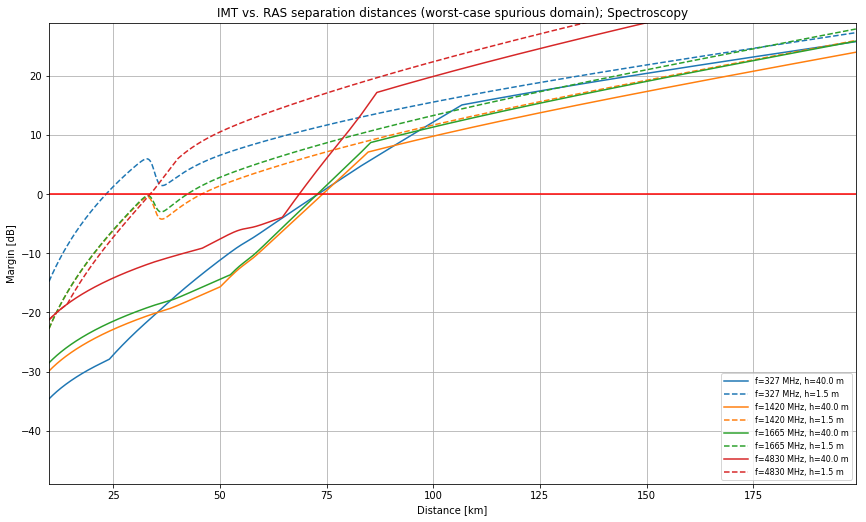

In [11]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.close()
fig = plt.figure(figsize=(14, 8))
ax = fig.add_axes((0.1, 0.1, 0.8, 0.8))
for freq, Plim_nu, color in zip(tab['frequency'], tab['Plim_nu'], colors):
    
    for height, ls in zip(HEIGHTS, ['-', '--']):

        dist, atten = path_atten(freq, height)
        
        margin = Plim_nu.to_value(cnv.dBm_MHz) - (
            P_spurious.to_value(cnv.dBm_MHz) - atten.to_value(cnv.dB)
            )
        
        ax.plot(
            dist, margin,
            ls=ls, c=color, label='f={:.0f}, h={:.1f}'.format(freq, height)
            )

ax.legend(
    *ax.get_legend_handles_labels(), 
    loc='lower right', fontsize=8, handlelength=3
    )
ax.axhline(0, c='r')
ax.set_xlim((10, 199))
ax.set_ylim((-49, 29))
ax.set_xlabel('Distance [km]')
ax.set_ylabel('Margin [dB]')
ax.grid()
ax.set_title('IMT vs. RAS separation distances (worst-case spurious domain); Spectroscopy')
plt.show()

### VLBI thresholds

In [12]:
tab = protection.ra769_limits(mode='vlbi')[5:11]

First, we need to augment the table with the power limits.

In [13]:
tab['Plim_nu'] = (
    tab['Slim_nu'].to(u.W / u.m ** 2 / u.Hz) / 4 / np.pi * con.c ** 2 / tab['frequency'] ** 2
    ).to(cnv.dB_W_Hz)

In [14]:
tab

frequency,T_A,T_rx,Slim_nu,Plim_nu
MHz,K,K,dB(W / (Hz m2)),dB(W / Hz)
float64,float64,float64,float64,float64
408,25,60,-215.6,-229.3
611,20,60,-212.4,-229.6
1414,12,10,-210.7,-235.2
1665,12,10,-209.3,-235.2
2695,12,10,-205.1,-235.2
4995,12,10,-199.7,-235.2


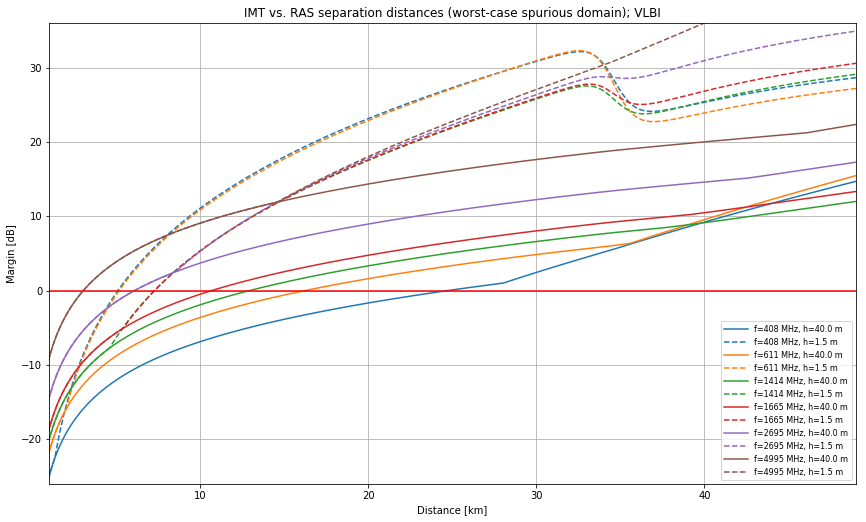

In [15]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.close()
fig = plt.figure(figsize=(14, 8))
ax = fig.add_axes((0.1, 0.1, 0.8, 0.8))
for freq, Plim_nu, color in zip(tab['frequency'], tab['Plim_nu'], colors):
    
    for height, ls in zip(HEIGHTS, ['-', '--']):

        dist, atten = path_atten(freq, height)
        
        margin = Plim_nu.to_value(cnv.dBm_MHz) - (
            P_spurious.to_value(cnv.dBm_MHz) - atten.to_value(cnv.dB)
            )
        
        ax.plot(
            dist, margin,
            ls=ls, c=color, label='f={:.0f}, h={:.1f}'.format(freq, height)
            )

ax.legend(
    *ax.get_legend_handles_labels(), 
    loc='lower right', fontsize=8, handlelength=3
    )
ax.axhline(0, c='r')
ax.set_xlim((1, 49))
ax.set_ylim((-26, 36))
ax.set_xlabel('Distance [km]')
ax.set_ylabel('Margin [dB]')
ax.grid()
ax.set_title('IMT vs. RAS separation distances (worst-case spurious domain); VLBI')
plt.show()